In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from myLibs.meteorologicalAnalysis import estimate_precipitation_percent

In [ ]:
# -----------------------------------------------------------------------------
# Step 0: Define file paths and severe-weather time window
# -----------------------------------------------------------------------------
input_path = "Data/Raw/RawDataset_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"
output_path = "Data/Exp/ProcessedData_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"

SEVERE_START = pd.Timestamp("2025-01-15 12:20")
SEVERE_END   = pd.Timestamp("2025-01-18 22:59")

# -----------------------------------------------------------------------------
# Step 1: Load raw weather data
# -----------------------------------------------------------------------------
df = pd.read_csv(input_path, parse_dates=['Timestamp'])

# -----------------------------------------------------------------------------
# Step 2: Estimate precipitation percentage
# -----------------------------------------------------------------------------
df['Precipitation_%'] = df.apply(
    lambda row: estimate_precipitation_percent(
        temp_c=row['Temperature_C'],
        wind_kmh=row['Wind_km_h'],
        humidity_pct=row['Humidity_%']
    ),
    axis=1
)

# # -----------------------------------------------------------------------------
# # Step 3: (Optional) Handle severe-weather period
# # -----------------------------------------------------------------------------
# # Example: ensure severe-weather period values aren’t scaled down or clipped.
# mask = (df['Timestamp'] >= SEVERE_START) & (df['Timestamp'] <= SEVERE_END)
# df.loc[mask, 'Precipitation_%'] = df.loc[mask, 'Precipitation_%'].clip(lower=80)
# # ↑ This ensures that during the severe window, precipitation likelihood is at least 80%.

# # -----------------------------------------------------------------------------
# # Step 4: Save processed dataset
# # -----------------------------------------------------------------------------
# df.to_csv(output_path, index=False)

# print(f"Processed dataset saved to: {output_path}")


# -----------------------------------------------------------------------------
# Step 3: Smooth the precipitation percentage with a centered moving average
# -----------------------------------------------------------------------------
# We use a 7-point window (≈3 hours on either side if data is hourly).
# center=True ensures the average is centered at each data point.
# min_periods=1 means that near edges (where fewer than 7 points exist), it will average
# whatever points are available.
df['Precipitation_%'] = (
    df['Precipitation_%']
    .rolling(window=3, center=True, min_periods=1)
    .mean()
    .round(2)
)


# -----------------------------------------------------------------------------
# Step 4: Scale down values outside the severe weather period
# -----------------------------------------------------------------------------
# Rationale:
#   - Outside the severe weather window, large spikes in precipitation_% may be
#     unrealistic. We will find the maximum observed precipitation_% outside the severe window.
#   - If that maximum exceeds 35%, we scale all outside values so that the new maximum is 14%.
#   - After scaling, any value below 7% is considered negligible and set to 0%.
#
# First, identify the maximum precipitation_% outside the severe-window.
mask_outside = (df['Timestamp'] < SEVERE_START) | (df['Timestamp'] > SEVERE_END)
max_outside_pct = df.loc[mask_outside, 'Precipitation_%'].max()

def scale_outside_severe(row):
    """
    For timestamps outside the severe window, scale the smoothed precipitation_%
    if the maximum outside % > 35. Then zero-out small values (< 7%).
    Inside the severe window, return the original smoothed percentage unchanged.
    """
    timestamp = row['Timestamp']
    pct_value = row['Precipitation_%']
    
    # Check if this row is outside the severe window:
    if (timestamp < SEVERE_START) or (timestamp > SEVERE_END):
        if max_outside_pct > 25.0:
            # Scale so that the previous max_outside_pct maps to 14% maximum
            # scaled = pct_value * (20.0 / max_outside_pct)
            scaled = pct_value * .001
        else:
            # If max_outside_pct ≤ 35%, do not scale; keep pct_value as-is
            scaled = pct_value
        
        # If the scaled value is below 7%, treat as no precipitation (0.0%)
        if scaled < 5.0:
            return 0.0
        else:
            return round(scaled, 2)
    
    # During the severe window, return the smoothed percentage unchanged
    return pct_value

# Apply the scaling function
# df['Precipitation_%'] = df.apply(scale_outside_severe, axis=1)


# -----------------------------------------------------------------------------
# Step 5: Re-apply smoothing to ensure no abrupt edges after scaling
# -----------------------------------------------------------------------------
# It’s useful to smooth again so that any discontinuities introduced by scaling are dampened.
df['Precipitation_%'] = (
    df['Precipitation_%']
    .rolling(window=3, center=True, min_periods=1)
    .mean()
    .round(2)
)


# -----------------------------------------------------------------------------
# Step 6: Drop 'Precipitation_mm' and Save the processed DataFrame to CSV
# -----------------------------------------------------------------------------
df.drop(columns=['Precipitation_mm'], inplace=True)
df.to_csv(output_path, index=False)

# ----------------------------------- END -------------------------------------

In [ ]:
df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set font globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "bold"

# Load the processed dataset with parsed timestamps
file_path = "Data/Exp/ProcessedData_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"
df = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot temperature, wind speed
ax1.plot(
    df['Timestamp'],
    df['Temperature_C'],
    label='Temperature (°C)',
    color='crimson',
    linewidth=3,
    marker='o',
    markersize=3,
    alpha=0.5
)
ax1.plot(
    df['Timestamp'],
    df['Wind_km_h'],
    label='Wind Speed (km/h)',
    color='navy',
    linewidth=3,
    marker='^',
    markersize=3,
    alpha=0.5
)

# Plot humidity and precipitation on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(
    df['Timestamp'],
    df['Humidity_%'],
    label='Humidity (%)',
    color='teal',
    linewidth=3,
    marker='s',
    markersize=3,
    alpha=0.5
)
ax2.plot(
    df['Timestamp'],
    df['Precipitation_%'],
    label='Precipitation (%)',
    color='coral',
    linewidth=3,
    marker='d',
    markersize=3,
    alpha=0.5
)

# Axis labels
ax1.set_xlabel('Timestamp (hr)', fontweight='bold')
ax1.set_ylabel('Temperature / Wind', fontweight='bold')
ax2.set_ylabel('Humidity / Precipitation', fontweight='bold')

# 1. Major ticks at 12:00 each day (so "10 Jan 2025" appears at midday)
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=12+1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

# 2. Minor ticks = every 6 hours
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# 3. Vertical grid lines at every 6h (minor ticks)
ax1.grid(which='minor', linestyle='--', color='coral', alpha=0.5)

# 3a. Horizontal grid lines at each y‐major tick
ax1.grid(which='major', axis='y', linestyle='--', color='coral', alpha=0.5)

ax2.grid(which='major', axis='y', linestyle='--', color='cyan', alpha=0.5)

# 4. Ensure no grid at x‐major ticks
ax1.grid(which='major', axis='x', color='coral', alpha=0.5, visible=True)

# 5. Fix x‐axis range: Jan 10 00:00 → Jan 20 23:00
# start = pd.Timestamp("2025-01-10 00:00")
# end   = pd.Timestamp("2025-01-20 23:00")
# ax1.set_xlim(start, end)

# 6. Keep x‐axis labels horizontal & set font size
ax1.tick_params(axis='x', rotation=0, labelsize=13)

# Remove or comment out this line so labels stay horizontal:
# fig.autofmt_xdate()

# Shade 15–19 Jan as severe weather
ax1.axvspan(
    pd.Timestamp("2025-01-15 14:20"),
    pd.Timestamp("2025-01-18 22:59"),
    color='salmon',
    alpha=0.3,
    label='Severe Weather Period'
)

# Merge legends from both axes + shaded patch
lines, labels   = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines + lines2,
    labels + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=True
)

plt.tight_layout()
plt.savefig(
    "Figures/Wollongong_Weather_10_20_Jan_2025.png",
    dpi=600,
    bbox_inches='tight'
)
# plt.show()


In [ ]:
df

In [ ]:
# %pip install statsmodels
# %pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [ ]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.api import VAR
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import xgboost as xgb

# Load dataset again (safe step)
df = pd.read_csv(file_path, parse_dates=["Timestamp"])
df.set_index("Timestamp", inplace=True)

# ===================
# 1. Preprocessing
# ===================
# Resample to 3-hour intervals (mean to smooth hourly data)
df_resampled = df.resample("3H").mean()

# Fill missing values with linear interpolation
df_resampled = df_resampled.interpolate(method="linear")

# Train-test split
train = df_resampled.loc["2024-12-01":"2025-01-09"]
test = df_resampled.loc["2025-01-10":"2025-01-20"]

# Features (all variables)
variables = df_resampled.columns.tolist()

# ===================
# 2. VAR Model
# ===================
# Fit VAR on training data
var_model = VAR(train)
selected_lag = var_model.select_order(12).aic  # choose lag by AIC
var_results = var_model.fit(selected_lag)

# Forecast horizon = length of test set
forecast_steps = len(test)
var_forecast = var_results.forecast(train.values[-selected_lag:], steps=forecast_steps)

# Convert forecast to DataFrame
var_pred = pd.DataFrame(var_forecast, index=test.index, columns=variables)

# Metrics for VAR
var_metrics = {}
for col in variables:
    rmse = np.sqrt(mean_squared_error(test[col], var_pred[col]))
    mae = mean_absolute_error(test[col], var_pred[col])
    var_metrics[col] = {"RMSE": rmse, "MAE": mae}

# ===================
# 3. XGBoost Model (multi-output via separate regressors)
# ===================

def create_lagged_features(data, lags=24):
    df_lagged = data.copy()
    for lag in range(1, lags+1):
        for col in data.columns:
            df_lagged[f"{col}_lag{lag}"] = data[col].shift(lag)
    return df_lagged.dropna()

# Create lagged dataset
lagged_df = create_lagged_features(df_resampled, lags=8)  # use 8*3h=24h lags

# Train-test split aligned with lagging
train_lagged = lagged_df.loc["2024-12-01":"2025-01-09"]
test_lagged = lagged_df.loc["2025-01-10":"2025-01-20"]

# X and y
X_train = train_lagged.drop(columns=variables)
y_train = train_lagged[variables]
X_test = test_lagged.drop(columns=variables)
y_test = test_lagged[variables]

# Train separate models for each variable
xgb_preds = pd.DataFrame(index=y_test.index)
xgb_metrics = {}

for col in variables:
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, max_depth=5, learning_rate=0.05)
    model.fit(X_train, y_train[col])
    preds = model.predict(X_test)
    xgb_preds[col] = preds

    rmse = np.sqrt(mean_squared_error(y_test[col], preds))
    mae = mean_absolute_error(y_test[col], preds)
    xgb_metrics[col] = {"RMSE": rmse, "MAE": mae}

# ===================
# 4. Present Results
# ===================
# import caas_jupyter_tools
results_summary = pd.DataFrame({
    "VAR_RMSE": {col: var_metrics[col]["RMSE"] for col in variables},
    "VAR_MAE": {col: var_metrics[col]["MAE"] for col in variables},
    "XGB_RMSE": {col: xgb_metrics[col]["RMSE"] for col in variables},
    "XGB_MAE": {col: xgb_metrics[col]["MAE"] for col in variables},
})

# caas_jupyter_tools.display_dataframe_to_user("Model Comparison Results", results_summary)

results_summary.head()


In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict

# Models
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# I/O
FILE = file_path

# -----------------------------
# 1) Load & resample to 3-hour
# -----------------------------
df = pd.read_csv(FILE, parse_dates=["Timestamp"]).set_index("Timestamp")
df_3h = df.resample("3H").mean().interpolate("linear")

# Keep consistent column order
vars_cols = ["Temperature_C", "Wind_km_h", "Humidity_%", "Precipitation_%"]
df_3h = df_3h[vars_cols]

# -----------------------------
# 2) Train / Test split
# -----------------------------
train_start = pd.Timestamp("2024-12-01")
train_end   = pd.Timestamp("2025-01-09 23:59:59")
test_start  = pd.Timestamp("2025-01-10")
test_end    = pd.Timestamp("2025-01-20 23:59:59")

train_df = df_3h.loc[train_start:train_end]
test_df  = df_3h.loc[test_start:test_end]

# -----------------------------
# 3) Sliding window builder
# -----------------------------
INPUT_L = 112   # 14 days @ 3h
OUTPUT_L = 24   # 3 days @ 3h
STEP = 1

def make_supervised(
    data: pd.DataFrame,
    input_len: int,
    output_len: int,
    step: int = 1,
) -> Tuple[np.ndarray, np.ndarray, List[pd.DatetimeIndex], List[pd.DatetimeIndex]]:
    """
    Builds supervised samples using a sliding window across the FULL sequence.
    X shape: [n_samples, input_len * n_features]
    Y shape: [n_samples, output_len] (single target variable not assumed here; will select per variable later)
    Returns:
        X_all, (placeholder Y, not used), input_index_list, output_index_list
    We'll compute Y per variable later to keep one X for all.
    """
    values = data.values  # shape [T, F]
    times = data.index
    F = values.shape[1]
    
    X_list = []
    in_inds = []
    out_inds = []
    # last starting index for which output window fits
    last_start = len(values) - input_len - output_len
    for start in range(0, last_start + 1, step):
        Xin = values[start:start+input_len, :].reshape(-1)  # flatten all features across time
        X_list.append(Xin)
        in_inds.append(times[start:start+input_len])
        out_inds.append(times[start+input_len:start+input_len+output_len])
    X_all = np.vstack(X_list)
    # placeholder Y (we'll ignore and compute per variable)
    Y_placeholder = np.zeros((X_all.shape[0], output_len))
    return X_all, Y_placeholder, in_inds, out_inds

# Build windows over the *entire* resampled range so we can filter into train/test by output window timestamps.
X_all, Y_ph, in_idx, out_idx = make_supervised(df_3h, INPUT_L, OUTPUT_L, STEP)

# Helper: find indices whose entire output window falls *within* the given [start, end]
def select_by_output_window(
    out_index_list: List[pd.DatetimeIndex],
    start: pd.Timestamp,
    end: pd.Timestamp
) -> np.ndarray:
    sel = []
    for i, out_ts in enumerate(out_index_list):
        if len(out_ts) == 0:
            continue
        if out_ts[0] >= start and out_ts[-1] <= end:
            sel.append(i)
    return np.array(sel, dtype=int)

# Training samples: output window ends on/before train_end, starts on/after train_start
train_sel = select_by_output_window(out_idx, train_start, train_end)
# Testing samples: output window fully inside test interval
test_sel  = select_by_output_window(out_idx, test_start, test_end)

# Sanity counts
train_count = len(train_sel)
test_count  = len(test_sel)

# -----------------------------
# 4) Prepare targets per variable
# -----------------------------
def build_targets_for_var(var_name: str, data: pd.DataFrame, in_windows: List[pd.DatetimeIndex], out_windows: List[pd.DatetimeIndex]) -> np.ndarray:
    y_list = []
    for out_ts in out_windows:
        y_list.append(data.loc[out_ts, var_name].values)
    return np.vstack(y_list)

# Build test and train Y per variable
Y_all = {v: build_targets_for_var(v, df_3h, in_idx, out_idx) for v in vars_cols}

# Slice to train/test sets
X_train = X_all[train_sel]
X_test  = X_all[test_sel]
Y_train_dict = {v: Y_all[v][train_sel] for v in vars_cols}
Y_test_dict  = {v: Y_all[v][test_sel]  for v in vars_cols}

# -----------------------------
# 5) XGBoost Direct Multi-step (24 heads) = train 24 models per variable
# -----------------------------
xgb_params = dict(
    objective="reg:squarederror",
    n_estimators=150,
    max_depth=4,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    n_jobs=2
)

xgb_models: Dict[str, List[xgb.XGBRegressor]] = {}
xgb_preds: Dict[str, np.ndarray] = {}
xgb_metrics: Dict[str, Dict[str, float]] = {}

for v in vars_cols:
    models_v = []
    preds_mat = np.zeros_like(Y_test_dict[v])
    # Train 24 horizon-specific models
    for h in range(OUTPUT_L):
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X_train, Y_train_dict[v][:, h])
        preds_mat[:, h] = model.predict(X_test)
        models_v.append(model)
    xgb_models[v] = models_v
    xgb_preds[v]  = preds_mat
    # Metrics averaged across 24 horizons
    rmse = float(np.sqrt(mean_squared_error(Y_test_dict[v].ravel(), preds_mat.ravel())))
    mae  = float(mean_absolute_error(Y_test_dict[v].ravel(), preds_mat.ravel()))
    xgb_metrics[v] = {"RMSE": rmse, "MAE": mae}

# -----------------------------
# 6) VAR Baseline (fit once on train range)
# -----------------------------
# Fit on the training *time segment* (not windowed)
var_train = train_df.copy()
# Choose lag by AIC up to 12
order_sel = VAR(var_train).select_order(12)
lag_opt = max(1, order_sel.aic)  # ensure >=1
var_fit = VAR(var_train).fit(lag_opt)

# For each test window start (the first timestamp of each out window), do a 24-step forecast
def var_forecast_for_window(var_fit, history_df: pd.DataFrame, start_time: pd.Timestamp, steps: int = 24) -> pd.DataFrame:
    """
    VAR predicts next 'steps' values given data up to start_time - 3h.
    We use all history up to the last input timestamp of that window.
    """
    # ensure we pass the last 'lag_opt' values for forecast
    # statsmodels accepts np.ndarray with last lag_opt rows
    hist_vals = history_df.values[-lag_opt:, :]
    fc = var_fit.forecast(y=hist_vals, steps=steps)
    return pd.DataFrame(fc, columns=history_df.columns)

# Build a growing history DF that appends real observations up to each test window start
# We'll reconstruct forecasts aligned with test_sel out windows
var_preds: Dict[str, np.ndarray] = {v: np.zeros_like(Y_test_dict[v]) for v in vars_cols}

# For efficiency, reuse the same var_fit but update the "history" slice per window
# Find the corresponding "input end time" for each test window = out_idx[i][0] - 3h
for j, idx in enumerate(test_sel):
    out_window = out_idx[idx]
    # The input window end time is the time just before out_window starts
    history_end_time = out_window[0] - pd.Timedelta(hours=3)
    # Use all available actual data up to history_end_time for history_df
    history_df = df_3h.loc[:history_end_time]
    # Use the *fitted* params to forecast 24 steps ahead from the last lag
    # We need last lag_opt rows:
    last_vals = history_df.values[-lag_opt:, :]
    fc = var_fit.forecast(y=last_vals, steps=OUTPUT_L)
    # Collect only the target columns
    for vi, v in enumerate(vars_cols):
        var_preds[v][j, :] = fc[:, vi]

# VAR metrics
var_metrics: Dict[str, Dict[str, float]] = {}
for v in vars_cols:
    rmse = float(np.sqrt(mean_squared_error(Y_test_dict[v].ravel(), var_preds[v].ravel())))
    mae  = float(mean_absolute_error(Y_test_dict[v].ravel(), var_preds[v].ravel()))
    var_metrics[v] = {"RMSE": rmse, "MAE": mae}

# -----------------------------
# 7) Summaries & outputs
# -----------------------------
summary_rows = []
for v in vars_cols:
    summary_rows.append({
        "Variable": v,
        "XGB_RMSE": xgb_metrics[v]["RMSE"],
        "XGB_MAE":  xgb_metrics[v]["MAE"],
        "VAR_RMSE": var_metrics[v]["RMSE"],
        "VAR_MAE":  var_metrics[v]["MAE"],
        "TrainWindows": int(train_count),
        "TestWindows": int(test_count),
        "InputPoints": INPUT_L,
        "OutputPoints": OUTPUT_L
    })
summary_df = pd.DataFrame(summary_rows).set_index("Variable")

# Save per-variable predictions for inspection
# Each CSV includes columns: horizon_0 ... horizon_23 and aligned to the *start time* of each test window
def save_pred_df(method_preds: Dict[str, np.ndarray], prefix: str):
    for v in vars_cols:
        dfp = pd.DataFrame(method_preds[v], index=[out_idx[i][0] for i in test_sel],
                           columns=[f"h{h}" for h in range(OUTPUT_L)])
        dfp.index.name = "forecast_start"
        dfp.to_csv(f"Data/Exp/{prefix}_pred_{v}.csv")

save_pred_df(xgb_preds, "XGB")
save_pred_df(var_preds, "VAR")

# Export the ground truth Y for convenience
Ytruth = {v: Y_test_dict[v] for v in vars_cols}
for v in vars_cols:
    dft = pd.DataFrame(Ytruth[v], index=[out_idx[i][0] for i in test_sel],
                       columns=[f"h{h}" for h in range(OUTPUT_L)])
    dft.index.name = "forecast_start"
    dft.to_csv(f"Data/Exp/Truth_{v}.csv")

# # Display summary
# import caas_jupyter_tools
# caas_jupyter_tools.display_dataframe_to_user("Sliding-Window Forecast Summary (14-day input, 3-day horizon)", summary_df)

# Provide file paths as a tiny text output to show they're created
summary_df


In [1]:
import pandas as pd

# Step 1: Read the dataset
df = pd.read_csv("Data/Exp/ProcessedData_Meteorological_Wollongong_01Dec24_to_20Jan25.csv",
                 parse_dates=["Timestamp"])

print(df.shape)
print(df.head())

(1186, 5)
            Timestamp  Temperature_C  Wind_km_h  Humidity_%  Precipitation_%
0 2024-12-01 00:00:00           20.0       15.0        92.0            67.09
1 2024-12-01 01:00:00           19.0       20.0        95.0            71.61
2 2024-12-01 02:00:00           19.0       22.0        95.0            77.00
3 2024-12-01 03:00:00           19.0       22.0        96.0            80.34
4 2024-12-01 04:00:00           19.0       13.0        96.0            79.11


In [2]:
df

,Timestamp,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%
0,2024-12-01 00:00:00,20.0,15.0,92.0,67.09
1,2024-12-01 01:00:00,19.0,20.0,95.0,71.61
2,2024-12-01 02:00:00,19.0,22.0,95.0,77.00
3,2024-12-01 03:00:00,19.0,22.0,96.0,80.34
4,2024-12-01 04:00:00,19.0,13.0,96.0,79.11
...,...,...,...,...,...
1181,2025-01-20 19:00:00,21.0,11.0,62.0,13.33
1182,2025-01-20 20:00:00,20.0,9.0,65.0,16.89
1183,2025-01-20 21:00:00,20.0,0.0,67.0,20.44
1184,2025-01-20 22:00:00,18.0,0.0,73.0,24.00


In [3]:
# Step 2: Resample the dataset to 3-hour intervals

# Ensure Timestamp is the index
df = df.set_index("Timestamp")

# Resample to 3-hour mean values and interpolate missing points
df_3h = df.resample("3H").mean().interpolate("linear")

print(df_3h.shape)
print(df_3h.head(20))

(408, 4)
                     Temperature_C  Wind_km_h  Humidity_%  Precipitation_%
Timestamp                                                                 
2024-12-01 00:00:00      19.333333  19.000000   94.000000        71.900000
2024-12-01 03:00:00      19.000000  15.333333   96.000000        76.743333
2024-12-01 06:00:00      21.333333  12.000000   86.333333        32.780000
2024-12-01 09:00:00      24.333333  14.000000   73.666667         9.073333
2024-12-01 12:00:00      23.333333  25.333333   79.333333        18.850000
2024-12-01 15:00:00      19.666667  15.333333   87.333333        35.333333
2024-12-01 18:00:00      19.333333  16.333333   88.000000        35.003333
2024-12-01 21:00:00      21.000000  15.666667   76.000000        18.740000
2024-12-02 00:00:00      21.000000  18.000000   79.666667        16.186667
2024-12-02 03:00:00      20.666667  12.000000   79.333333        14.926667
2024-12-02 06:00:00      22.000000  16.000000   70.333333        13.850000
2024-12-02 09:00

C:\Users\rbmxu\AppData\Local\Temp\ipykernel_50844\1967579530.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_3h = df.resample("3H").mean().interpolate("linear")


In [4]:
df_3h

,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%
Timestamp,,,,
2024-12-01 00:00:00,19.333333,19.000000,94.000000,71.900000
2024-12-01 03:00:00,19.000000,15.333333,96.000000,76.743333
2024-12-01 06:00:00,21.333333,12.000000,86.333333,32.780000
2024-12-01 09:00:00,24.333333,14.000000,73.666667,9.073333
2024-12-01 12:00:00,23.333333,25.333333,79.333333,18.850000
...,...,...,...,...
2025-01-20 09:00:00,21.666667,15.666667,54.666667,13.000000
2025-01-20 12:00:00,22.000000,15.666667,57.333333,9.333333
2025-01-20 15:00:00,22.000000,13.000000,56.000000,9.146667


In [9]:
import numpy as np

INPUT_L = 56   # 7 days @ 3h
OUTPUT_L = 24  # 3 days @ 3h

X_list, Y_list = [], []

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_3h.values)

# rebuild windows using scaled values
values = scaled_values  # numpy array

times = df_3h.index

last_start = len(values) - INPUT_L - OUTPUT_L - 112

for start in range(last_start + 1):
    X = values[start:start+INPUT_L, :]        # input window
    Y = values[start+INPUT_L:start+INPUT_L+OUTPUT_L, :]  # output horizon
    X_list.append(X)
    Y_list.append(Y)

X_arr = np.array(X_list)  # shape: [n_windows, 56, n_features]
Y_arr = np.array(Y_list)  # shape: [n_windows, 24, n_features]

print("X shape:", X_arr.shape)
print("Y shape:", Y_arr.shape)
print("First input window:", times[0:56][0], "→", times[0:56][-1])
print("First output window:", times[56], "→", times[56+24-1])


X shape: (217, 56, 4)
Y shape: (217, 24, 4)
First input window: 2024-12-01 00:00:00 → 2024-12-07 21:00:00
First output window: 2024-12-08 00:00:00 → 2024-12-10 21:00:00


In [10]:
import xgboost as xgb

# Flatten input for XGBoost
X_flat = X_arr.reshape(X_arr.shape[0], -1)
Y_flat = Y_arr.reshape(Y_arr.shape[0], -1)  # flatten output as well

# Train one model per output step for Temperature (column 0 as example)
models = []
preds = []
for h in range(OUTPUT_L):
    y_target = Y_arr[:, h, 0]   # Temperature only
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, max_depth=4)
    model.fit(X_flat, y_target)
    y_pred = model.predict(X_flat)
    preds.append(y_pred)
    models.append(model)

preds = np.array(preds).T  # shape: (n_windows, 24)
print("Predictions shape:", preds.shape)

Predictions shape: (217, 24)


C:\Users\rbmxu\AppData\Local\Temp\ipykernel_50844\3087468504.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_range = pd.date_range(start=start_time, periods=OUTPUT_L, freq="3H")


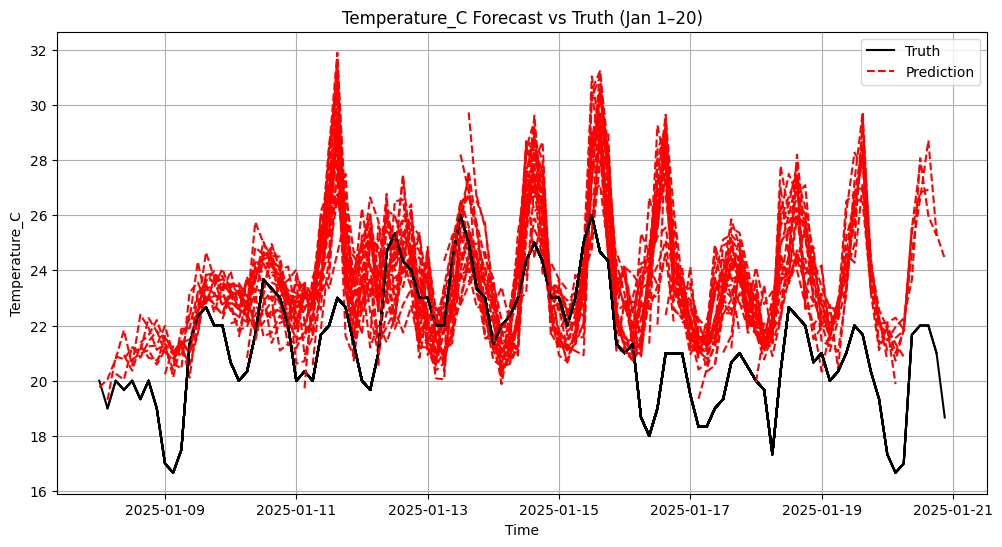

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
INPUT_L = 56   # 7 days (3h steps)
OUTPUT_L = 24  # 3 days (3h steps)

# Pick Temperature (column 0)
var_idx = 0
var_name = df_3h.columns[var_idx]

# Restrict to Jan 1–20
jan_df = df_3h.loc["2025-01-01":"2025-01-20"]
jan_values = scaler.transform(jan_df.values)  # scale with same scaler
jan_times = jan_df.index

predictions = []
truths = []
start_times = []

for day_shift in range(len(jan_values) - INPUT_L - OUTPUT_L + 1):
    in_start = day_shift
    in_end   = day_shift + INPUT_L
    out_end  = in_end + OUTPUT_L
    
    # stop if forecast exceeds Jan 20
    if out_end > len(jan_values):
        break
    
    X_input = jan_values[in_start:in_end, :].reshape(1, -1)
    
    # predict with trained models (24 horizons)
    y_preds_scaled = [models[h].predict(X_input)[0] for h in range(OUTPUT_L)]
    y_preds_scaled = np.array(y_preds_scaled)
    
    # inverse transform to real units
    y_preds_real = y_preds_scaled * scaler.data_range_[var_idx] + scaler.data_min_[var_idx]
    
    # ground truth
    y_true_real = jan_df.iloc[in_end:out_end, var_idx].values
    
    predictions.append(y_preds_real)
    truths.append(y_true_real)
    start_times.append(jan_times[in_end])   # first forecasted timestamp
    
# Convert to arrays
predictions = np.array(predictions)  # shape: (n_windows, 24)
truths = np.array(truths)

# ==== Plot ====
plt.figure(figsize=(12,6))
for i, start_time in enumerate(start_times):
    t_range = pd.date_range(start=start_time, periods=OUTPUT_L, freq="3H")
    plt.plot(t_range, truths[i], color="black", label="Truth" if i==0 else "")
    plt.plot(t_range, predictions[i], color="red", linestyle="--", label="Prediction" if i==0 else "")

plt.title(f"{var_name} Forecast vs Truth (Jan 1–20)")
plt.xlabel("Time")
plt.ylabel(var_name)
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import pandas as pd
import numpy as np

# predictions, truths: shape (n_windows, 24)
# start_times = list of forecast start timestamps (len = n_windows)

pred_rows = []
truth_rows = []
cols = None

for i, start in enumerate(start_times):
    # each forecast covers next 24 steps at 3h interval
    times = pd.date_range(start=start, periods=predictions.shape[1], freq="3H")
    if cols is None:
        cols = times  # fix columns to actual timestamps
    
    pred_rows.append(pd.Series(predictions[i], index=times, name=start))
    truth_rows.append(pd.Series(truths[i], index=times, name=start))

pred_df = pd.DataFrame(pred_rows, columns=cols)
truth_df = pd.DataFrame(truth_rows, columns=cols)

pred_df.index.name  = "forecast_start"
truth_df.index.name = "forecast_start"

print(pred_df.head())
print(truth_df.head())

                2025-01-08 00:00:00  2025-01-08 03:00:00  2025-01-08 06:00:00  \
forecast_start                                                                  
2025-01-08                19.759884            20.051399            20.794188   
2025-01-09                      NaN                  NaN                  NaN   
2025-01-10                      NaN                  NaN                  NaN   
2025-01-11                      NaN                  NaN                  NaN   
2025-01-12                      NaN                  NaN                  NaN   

                2025-01-08 09:00:00  2025-01-08 12:00:00  2025-01-08 15:00:00  \
forecast_start                                                                  
2025-01-08                 21.82852            20.551298            22.395687   
2025-01-09                      NaN                  NaN                  NaN   
2025-01-10                      NaN                  NaN                  NaN   
2025-01-11                 

C:\Users\rbmxu\AppData\Local\Temp\ipykernel_50844\2613999042.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(start=start, periods=predictions.shape[1], freq="3H")


In [15]:
truth_df

,2025-01-08 00:00:00,2025-01-08 03:00:00,2025-01-08 06:00:00,2025-01-08 09:00:00,2025-01-08 12:00:00,2025-01-08 15:00:00,2025-01-08 18:00:00,2025-01-08 21:00:00,2025-01-09 00:00:00,2025-01-09 03:00:00,...,2025-01-09 18:00:00,2025-01-09 21:00:00,2025-01-10 00:00:00,2025-01-10 03:00:00,2025-01-10 06:00:00,2025-01-10 09:00:00,2025-01-10 12:00:00,2025-01-10 15:00:00,2025-01-10 18:00:00,2025-01-10 21:00:00
forecast_start,,,,,,,,,,,,,,,,,,,,,
2025-01-08,20.0,19.0,20.0,19.666667,20.0,19.333333,20.0,19.0,17.0,16.666667,...,22.0,22.0,20.666667,20.000000,20.333333,21.666667,23.666667,23.333333,23.0,22.000000
2025-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,20.000000,...,19.0,17.0,16.666667,17.500000,21.333333,22.333333,22.666667,22.000000,22.0,20.666667
2025-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20.000000,19.666667,20.000000,19.333333,20.000000,19.000000,17.0,16.666667
2025-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def rmse(a, b): 
    return float(np.sqrt(mean_squared_error(a.ravel(), b.ravel())))

def mae(a, b): 
    return float(mean_absolute_error(a.ravel(), b.ravel()))

overall_rmse = rmse(truths, predictions)
overall_mae  = mae(truths, predictions)

print("OVERALL metrics for Jan 1–20 (all horizons combined):")
print(f"RMSE: {overall_rmse:.4f}")
print(f"MAE : {overall_mae:.4f}")


OVERALL metrics for Jan 1–20 (all horizons combined):
RMSE: 2.9503
MAE : 2.3639


In [16]:
df_3h

,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%
Timestamp,,,,
2024-12-01 00:00:00,19.333333,19.000000,94.000000,71.900000
2024-12-01 03:00:00,19.000000,15.333333,96.000000,76.743333
2024-12-01 06:00:00,21.333333,12.000000,86.333333,32.780000
2024-12-01 09:00:00,24.333333,14.000000,73.666667,9.073333
2024-12-01 12:00:00,23.333333,25.333333,79.333333,18.850000
...,...,...,...,...
2025-01-20 09:00:00,21.666667,15.666667,54.666667,13.000000
2025-01-20 12:00:00,22.000000,15.666667,57.333333,9.333333
2025-01-20 15:00:00,22.000000,13.000000,56.000000,9.146667


In [18]:
import pandas as pd

vars_cols = ["Temperature_C", "Wind_km_h", "Humidity_%", "Precipitation_%"]
OUTPUT_L = 24  # 3 days @ 3h

def window_times(forecast_start, steps=OUTPUT_L):
    return pd.date_range(start=forecast_start, periods=steps, freq="3H")

def last_valid_forecast_start(df_3h, steps=OUTPUT_L):
    return df_3h.index.max() - pd.Timedelta(hours=3*(steps-1))

# --- choose a valid window ---
fv_start = pd.Timestamp("2025-01-18 00:00:00")  # <= last_valid_forecast_start(df_3h)

# guard:
lv = last_valid_forecast_start(df_3h)
if fv_start > lv:
    raise ValueError(f"forecast_start must be <= {lv}")

# build actuals for this window
t_range = window_times(fv_start)
actual_df = df_3h.loc[t_range, vars_cols].copy()
actual_df.index.name = "Timestamp"
print(actual_df.head())

                     Temperature_C  Wind_km_h  Humidity_%  Precipitation_%
Timestamp                                                                 
2025-01-18 00:00:00      20.000000  67.000000   71.000000        47.440000
2025-01-18 03:00:00      19.666667  68.666667   78.000000        56.593333
2025-01-18 06:00:00      17.333333  42.333333   95.333333        91.743333
2025-01-18 09:00:00      20.333333  48.333333   92.333333        76.663333
2025-01-18 12:00:00      22.666667  44.666667   82.000000        41.076667


C:\Users\rbmxu\AppData\Local\Temp\ipykernel_50844\1817285492.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(start=forecast_start, periods=steps, freq="3H")


In [19]:
import pandas as pd
import numpy as np

INPUT_L = 56        # 7 days @ 3h
OUTPUT_L = 24       # 3 days @ 3h
STEP_H = 3
vars_cols = ["Temperature_C","Wind_km_h","Humidity_%","Precipitation_%"]

def last_valid_forecast_start(df_3h, output_l=OUTPUT_L):
    return df_3h.index.max() - pd.Timedelta(hours=STEP_H*(output_l-1))

# ---- CHOOSE a valid forecast_start (<= last_valid) ----
forecast_start = pd.Timestamp("2025-01-18 00:00:00")   # change if you like
lv = last_valid_forecast_start(df_3h)
assert forecast_start <= lv, f"forecast_start must be <= {lv}"

# ---- Build input window (last 56 points before forecast_start) ----
in_end_idx = df_3h.index.get_loc(forecast_start)        # first predicted time
in_start_idx = in_end_idx - INPUT_L                     # inclusive
X_input_real = df_3h.iloc[in_start_idx:in_end_idx, :].values  # (56, 4)

# Scale with the SAME scaler you fit earlier
X_input_scaled = scaler.transform(X_input_real)         # (56, 4)
X_input_flat = X_input_scaled.reshape(1, -1)            # (1, 56*4)

# ---- Predict 24 horizons for all 4 variables (scaled -> inverse to real units) ----
data_min   = scaler.data_min_
data_range = scaler.data_range_

pred_mat = np.zeros((OUTPUT_L, len(vars_cols)), dtype=float)   # (24, 4)

for j, v in enumerate(vars_cols):
    for h in range(OUTPUT_L):
        yhat_scaled = models[v][h].predict(X_input_flat)[0]    # scalar
        pred_mat[h, j] = yhat_scaled * data_range[j] + data_min[j]

# ---- Build aligned time index for the 24 forecast steps ----
t_range = pd.date_range(start=forecast_start, periods=OUTPUT_L, freq=f"{STEP_H}H")

# ---- Prediction DF (what you asked for) ----
pred_df = pd.DataFrame(pred_mat, index=t_range, columns=vars_cols)
pred_df.index.name = "Timestamp"

# ---- Actual DF at the same timestamps ----
actual_df = df_3h.loc[t_range, vars_cols].copy()
actual_df.index.name = "Timestamp"

print("PREDICTIONS:")
print(pred_df.head(12))
print("\nACTUALS:")
print(actual_df.head(12))


TypeError: list indices must be integers or slices, not str